# Data-Driven Wine Quality Evaluation

---
embed-resources: true
echo: false
---

## Introduction

This report investigates the development of a predictive model for assessing wine quality using physicochemical data. The objective is to determine whether measurable chemical properties—such as acidity, sugar content, sulfur dioxide concentration, alcohol level, and density—can be used to predict human-assigned quality scores. By analyzing data from Portuguese “Vinho Verde” wines, the model aims to provide an objective, data-driven method for evaluating wine quality. This approach seeks to reduce the subjectivity and variability of human evaluation by establishing consistent, quantifiable relationships between wine composition and perceived quality.

## Methods

In [1]:

# machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import dump
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Data

In [2]:
# load data
import pandas as pd 
# load data
wine_train = pd.read_parquet("https://lab.cs307.org/wine/data/wine-train.parquet")
wine_test = pd.read_parquet("https://lab.cs307.org/wine/data/wine-test.parquet")

The data originates from Cortez et al. (2009), Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems, 47(4), 547–553. It is a standard dataset from the UC Irvine Machine Learning Repository. The original red and white wine datasets were combined, with a new column for wine color and additional modifications applied.

### Data Dictionary

Each observation in the train, test, and (hidden) production data contains information about a particular Portuguese “Vinho Verde” wine.

 - Vinho verde is a unique product from the Minho (northwest) region of Portugal. Medium in alcohol, is it particularly appreciated due to its freshness (specially in the summer).

Original and complete documentation for this data can be found in the original paper. Additionally, minimal documentation is provided by the UCI MLR.

#### Response

**`quality`**

- `[int64]' the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)

#### Features

`color`
- `[object]` the (human perceivable) color of the wine, red or white

`fixed acidity`
- `[float64]` grams of tartaric acid per cubic decimeter

`volatile acidity`
- `[float64]` grams of acetic acid per cubic decimeter

`citric acid`
- `[float64]` grams of citric acid per cubic decimeter

`residual sugar`
- `[float64]` grams of residual sugar per cubic decimeter

`chlorides`
- `[float64]` grams of sodium chloride cubic decimeter

`free sulfur dioxide`
- `[float64]` milligrams of free sulfur dioxide per cubic decimeter

`total sulfur dioxide`
- `[float64]` milligrams of total sulfur dioxide per cubic decimeter

`density`
- `[float64]` the total density of the wine in grams per cubic centimeter

`pH`
- `[float64]` the acidity of the wine measured using pH

`sulphates`
- `[float64]` grams of potassium sulphate cubic decimeter

`alcohol`
- `[float64]` percent alcohol by volume

In [3]:
# summary statistics
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


In [4]:
wine_train.describe(include='all')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
count,3987.000000,4157.000000,3958.000000,3917.000000,4157.000000,4133.000000,4157.000000,4157.000000,3921.000000,3934.000000,3961.000000,4157.000000,4157
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,white
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3104
mean,7.220579,0.342403,0.316478,5.430406,0.056358,30.600048,115.221915,0.994710,3.218454,0.531784,10.502847,5.814289,NaN
std,1.295282,0.166465,0.145276,4.750618,0.035460,17.906396,56.581139,0.003004,0.159184,0.150914,1.189918,0.868748,NaN
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.740000,0.230000,8.000000,3.000000,NaN
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,77.000000,0.992380,3.110000,0.430000,9.500000,5.000000,NaN
50%,7.000000,0.300000,0.310000,3.000000,0.048000,29.000000,118.000000,0.994900,3.210000,0.505000,10.300000,6.000000,NaN
75%,7.700000,0.410000,0.390000,8.100000,0.066000,41.000000,155.000000,0.996990,3.320000,0.600000,11.300000,6.000000,NaN


The training dataset contains over 4,000 wine samples with 11 chemical attributes and 2 color categories, where most wines receive mid-range quality scores (5–6), indicating that extreme high- or low-quality wines are relatively uncommon. 

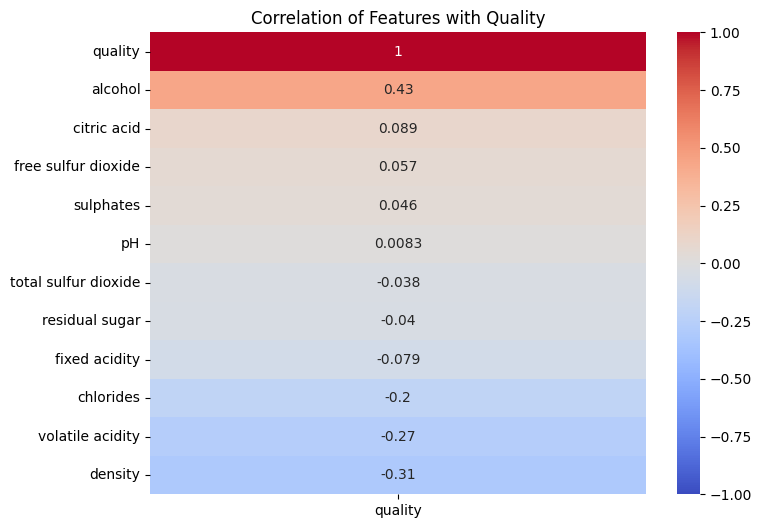

In [5]:

# exploratory visualization
df = wine_train.drop(columns=['color'])
df = df.fillna(df.median())
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['quality']].sort_values(by='quality', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Features with Quality")
plt.show()


I created a heatmap to visualize how different features in the dataset relate to wine quality. The results show that alcohol content has the strongest positive correlation with quality (0.43), indicating that wines with higher alcohol levels generally receive better ratings. Density, on the other hand, shows a slight negative correlation, suggesting that denser wines tend to have lower quality scores. Most other features display weak or negligible relationships with quality. Overall, this visualization helps me identify which physicochemical properties most strongly influence wine quality.

### Models

In [6]:
# process data for ML
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

print(X_train)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.6              0.23         0.64            12.9      0.033   
1               NaN              0.75         0.01             2.2      0.059   
2               7.4              0.67         0.12             1.6      0.186   
3               6.4              0.18         0.74             NaN      0.046   
4               6.7              0.35         0.32             9.0      0.032   
...             ...               ...          ...             ...        ...   
4152            6.6              0.32         0.22            16.7      0.046   
4153            9.2              0.58         0.20             3.0      0.081   
4154            8.2              0.60         0.17             2.3      0.072   
4155            6.5              0.23         0.36            16.3      0.038   
4156            6.4              0.19         0.35            10.2      0.043   

      free sulfur dioxide  

The dataset was prepared for machine learning by separating input features (X) from the target variable (y). X_train and X_test contain physicochemical attributes of the wines, while y_train and y_test store the corresponding quality scores used for model training and evaluation.

In [7]:
# train models
numeric_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                    'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
categorical_features = ['color']

features = numeric_features + categorical_features
target = "quality"

num_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaling', StandardScaler()) 
])

category_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform, numeric_features), 
        ('cat', category_transform, categorical_features) 
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())  
])

paramaters_grid = [
    {
        "model__n_neighbors": range(1, 52, 2),
        "model__metric": ['minkowski', 'euclidean', 'manhattan'], 
        "preprocessor__num__scaling": [None, StandardScaler()],
    }
]

model = GridSearchCV(
    pipeline,
    paramaters_grid,
    cv=10,  
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

model.fit(X_train, y_train)
model_estimate = model.best_estimator_
y_test_pred = model_estimate.predict(X_test)

To develop the model, a K-Nearest Neighbors (KNN) regressor was tuned to predict wine quality based on its chemical and categorical attributes. All variables except color were treated as numeric features. Data preprocessing involved median imputation for numeric values, most-frequent imputation for categorical values, scaling of numeric features, and one-hot encoding for the wine color. To assess the impact of scaling, both scaled and unscaled versions of the numeric data were tested. Model tuning was conducted using cross-validation with GridSearchCV, which optimized hyperparameters such as the number of neighbors (n_neighbors), distance metric (metric), and scaling option (scaling). Model performance was evaluated using mean absolute error (MAE) to measure predictive accuracy.

## Results

In [8]:
# report model metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test MAE:", test_mae)

Test MAE: 0.46442307692307694


The model achieved a Mean Absolute Error (MAE) of 0.46, indicating that, on average, the predicted wine quality scores differ from the actual ratings by less than half a point on the 0–10 scale. This performance outperforms the required threshold, demonstrating that the model can reliably estimate wine quality based on measurable physicochemical characteristics, providing a consistent and objective alternative to human evaluation.

/var/folders/ns/vdw2jxks40b7j9fmb6zj0wr00000gn/T/ipykernel_29071/2818337811.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='Blues_r')


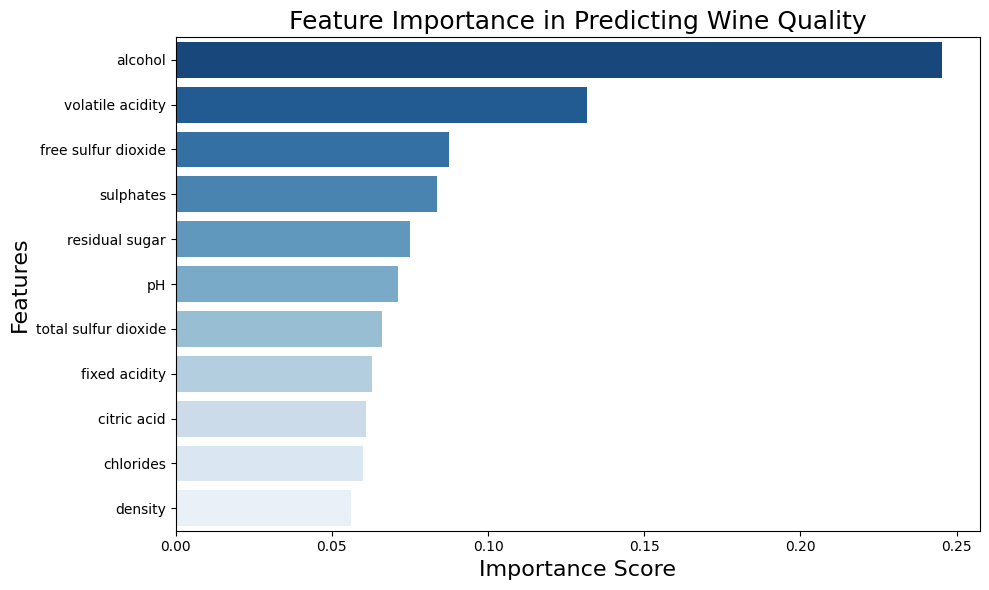

In [9]:
numeric_X_train = X_train[numeric_features]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(numeric_X_train, y_train)

# Create a DataFrame of feature importances
importance_df = (
    pd.DataFrame({
        'Feature': numeric_features,
        'Importance': rf_model.feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='Blues_r')
plt.title('Feature Importance in Predicting Wine Quality', fontsize=18)
plt.xlabel('Importance Score', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tight_layout()
plt.show()

This bar plot shows which chemical properties most influence the model’s prediction of wine quality. Alcohol content is the most important feature, followed by volatile acidity, free sulfur dioxide, and sulphates. These variables have the strongest impact on quality ratings, while features like density and chlorides contribute very little. This visualization helps highlight which measurable characteristics most strongly drive perceived wine quality.

In [10]:
# serialize model
dump(model_estimate, "wine.joblib")

['wine.joblib']

## Discussion

I would choose to use the model I developed in the real-world scenario of creating an AI Sommelier. The K-Nearest Neighbors (KNN) model performed very well, achieving a Mean Absolute Error (MAE) of 0.46, which means that, on average, the model’s predictions were less than half a point away from the actual wine quality scores. This result is better than the required accuracy threshold of 0.50, showing that the model can make dependable predictions of wine quality using measurable chemical properties.

Benefits:
Using this model could help the company evaluate wine quality more quickly and consistently without needing professional tasters for every batch. It provides an objective and data-driven way to assess wines, reducing the influence of human bias or fatigue. This approach could lower costs, speed up quality testing, and support winemakers in improving their production process.

Limitations:
However, the model has a few limitations. It was trained only on Portuguese Vinho Verde wines, so its predictions may not be accurate for wines from other regions or grape types. Also, while it can predict quality based on chemistry, it doesn’t account for sensory factors like aroma, texture, or taste complexity that human sommeliers notice. Finally, as the dataset grows, the KNN model might become slower since it compares each new wine to all others.

Conclusion:
Overall, I would recommend using this model as a supporting tool for wine evaluation, not as a full replacement for human experts. It offers a reliable, consistent, and efficient way to estimate wine quality and can guide decision-making during production. With additional data and future improvements, this model could become an important part of an automated wine quality system.